# Notebook for checking advanced `pyforce` functionalities
This notebook is not meant to be a tutorial, but a full execution (offline and online) of the advanced functionalities of `pyforce` starting from a toy dataset from a 2-group Neutron Diffusion problem, either in 1D or 2D.
In particular, the following methods are tested:

- Generalised Empirical Interpolation methods with random noise
- Indirect Reconstruction

## Toy Dataset
Let $\phi_1(\mathbf{x}, \boldsymbol{\mu})$ and $\phi_2(\mathbf{x}, \boldsymbol{\mu})$ be the fast and thermal neutron flux, respectively, with $ \mathbf{x}\in\Omega = [0, 1]^n$, given $n={1,2}$. They are the solution of a 2-groups diffusion problem for neutron by neglecting upscattering and assuming the material to be non-multiplying (no fission is present)

\begin{equation*}
\left\{
\begin{split}
    -\nabla\cdot (D_1\nabla\phi_1)+\left(\Sigma_{a,1}+\Sigma_{s, 1\rightarrow 2}\right)\phi_1&=S_1(\mathbf{x};  \mu_1, \mu_2)\\
    -\nabla\cdot (D_2\nabla\phi_2)+\Sigma_{a,2}\phi_2-\Sigma_{s, 1\rightarrow 2}\phi_{1}&=S_2(\mathbf{x}; \mu_1, \mu_2)
\end{split}
\right.
\end{equation*}

The source terms are defined as follows

\begin{equation*}
S_1(\mathbf{x};  \mu_1, \mu_2) = \sin(\mu_1\,\pi\,x)\cdot e^{-\frac{||\mathbf{x}-0.5||^2}{\mu_2}}\qquad\qquad
S_2(\mathbf{x};  \mu_1, \mu_2) = \cos(\mu_1\,\pi\,y)\cdot e^{-\frac{||\mathbf{x}-0.25||^2}{\mu_2}}
\end{equation*}

Either in 1D or 2D, homogeneous Dirichlet conditions are imposed at the boundary.
The parameters $\boldsymbol{\mu}\in\mathcal{D}\subset\mathbb{R}^2$ is given by
\begin{equation*}
\mu_1 \in [1,3] \qquad \qquad \mu_2 \in [0.2, 0.5]
\end{equation*}

Let us define the dataset, by generating the domain and the snapshots.

In [30]:
from toy_data import *

domain, V = toy_domain(Nh = 20, gdim = 2)
params, _snaps = toy_neutronic_dataset(domain, Ns = [25, 25])

true_snaps = {'phi1': FunctionsList(V), 'phi2': FunctionsList(V)}
tex_var_names = [r'\phi_1', r'\phi_2']
var_names = list(true_snaps.keys())

for snap in _snaps._list:
    true_snaps['phi1'].append(snap[::2])
    true_snaps['phi2'].append(snap[1::2])

Creating Dataset: 625.000 / 625.00 - 0.004 s/it


Let us normalize the snapshots between 0 and 1, using the min-max normalisation.

In [32]:
snaps = {'phi1': FunctionsList(V), 'phi2': FunctionsList(V)}

for field in snaps.keys():
    _min = min(true_snaps[field].return_matrix().flatten())
    _max = max(true_snaps[field].return_matrix().flatten())
    
    for snap in true_snaps[field]._list:
        snaps[field].append( (snap - _min) / (_max - _min))

Let us plot some of the snapshots

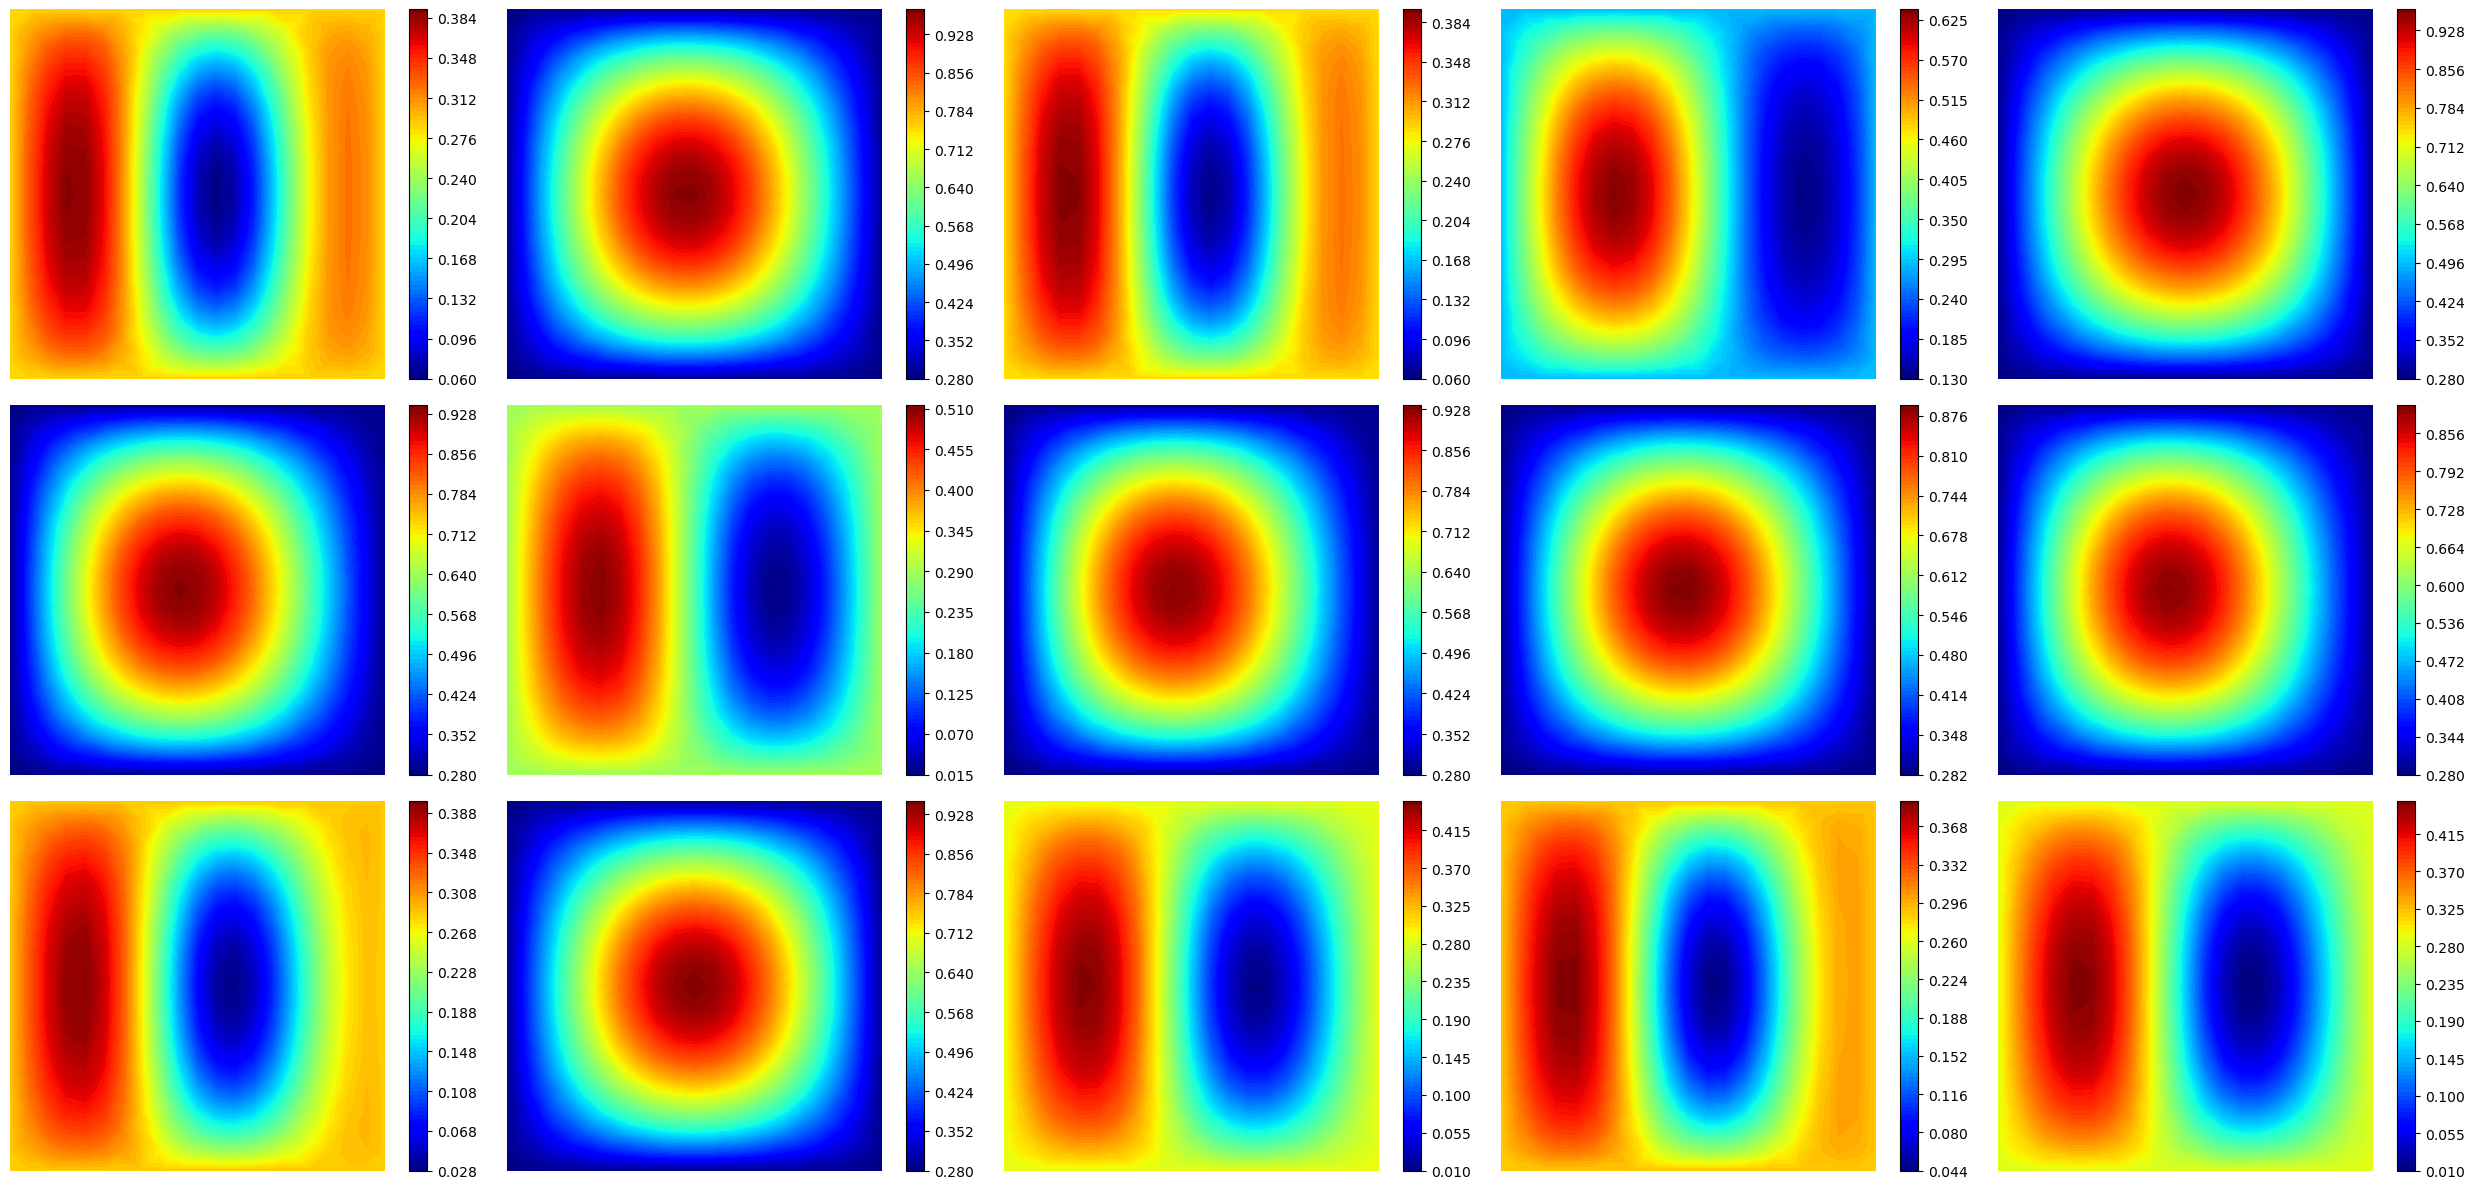

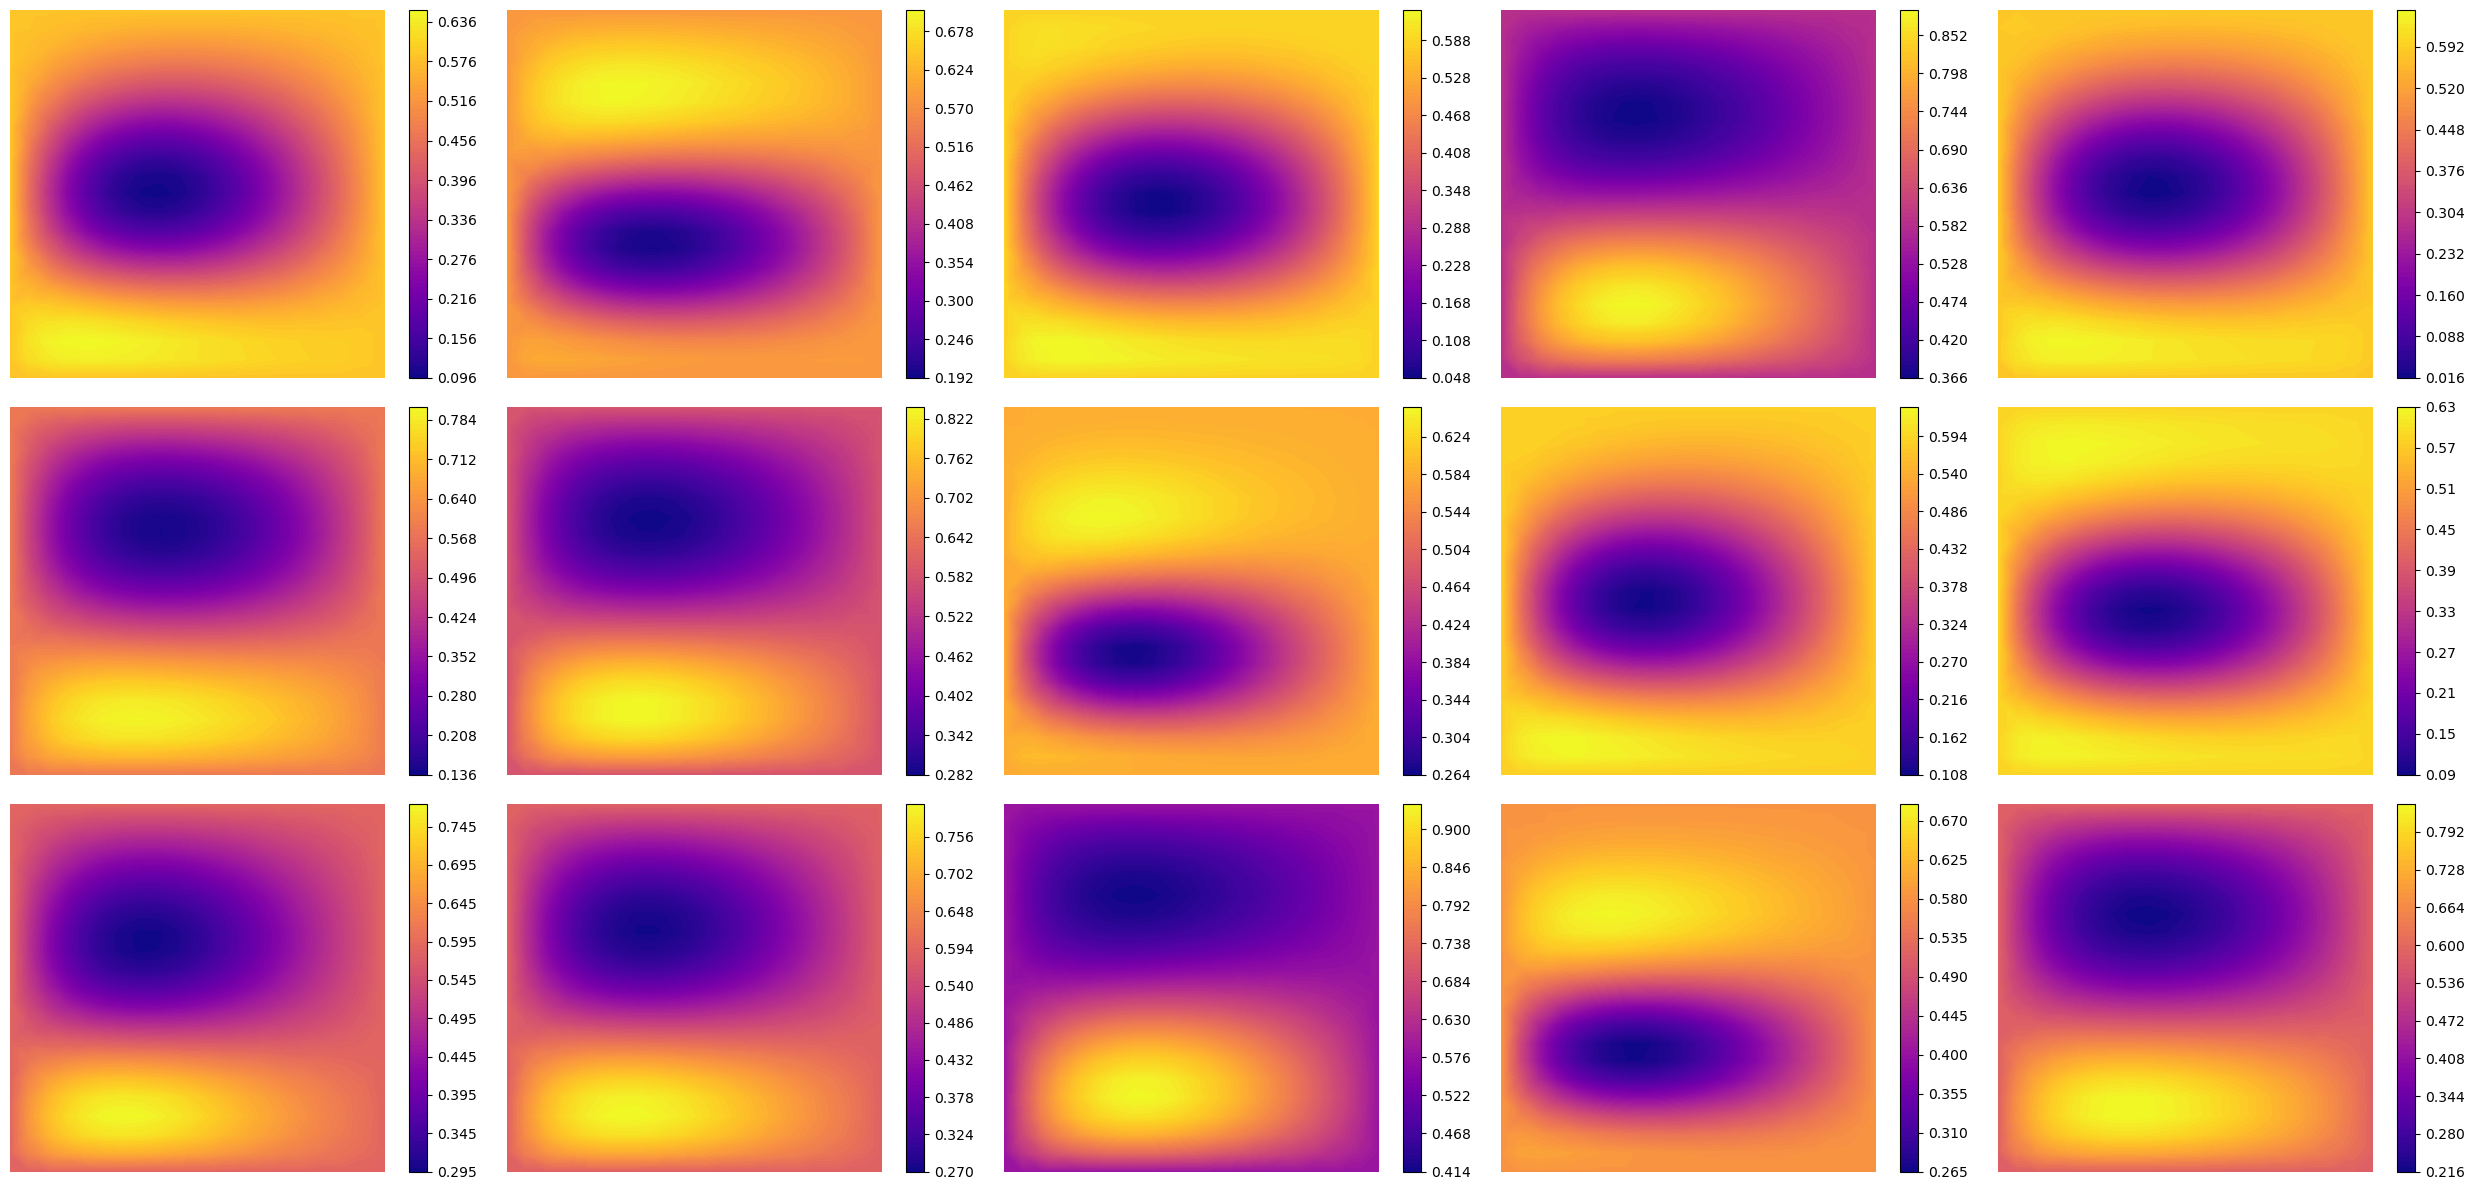

In [33]:
import matplotlib.pyplot as plt
from matplotlib import cm

cmaps = [cm.jet, cm.plasma]

for field_i in range(len(var_names)):
    fig, axs = plt.subplots(3,5, figsize=(5 * 5, 4 * 3))

    axs = axs.flatten()
    mesh_ = domain.geometry.x

    mu_to_plot = np.random.choice(len(snaps[var_names[field_i]]), 15, replace=False)

    for ii in range(len(axs)):
        plot1 = axs[ii].tricontourf(mesh_[:,0], mesh_[:,1], snaps[var_names[field_i]](mu_to_plot[ii]),  cmap=cmaps[field_i], levels=100) 
        plt.colorbar(plot1)
        axs[ii].axis('off')
        
    plt.tight_layout()
    plt.show()

Let us split it into train and test, randomly

In [34]:
from pyforce.tools.functions_list import train_test_split

mu_train = dict()
mu_test  = dict()

train_snaps = dict()
test_snaps  = dict()

for field_i in range(len(var_names)):
    splitting = train_test_split(params, snaps[var_names[field_i]], test_size=0.2)
    
    mu_train[var_names[field_i]] = splitting[0]
    mu_test[var_names[field_i]]  = splitting[1]
    
    train_snaps[var_names[field_i]] = FunctionsList(V)
    train_snaps[var_names[field_i]]._list = splitting[2].copy()
    
    test_snaps[var_names[field_i]] = FunctionsList(V)
    test_snaps[var_names[field_i]]._list = splitting[3].copy()

Let us define the structures to save the errors, the coefficients, the basis functions and sensors.

In [35]:
offline_errors = dict()

offline_coefficients = dict()

basis_functions = dict()
basis_sensors   = dict()

## Offline Phase
In this section, the reduced basis are generated along with the sensors.

### Proper Orthogonal Decomposition
The reduction via POD is performed, the correlation matrix formulation is used.

In [36]:
from pyforce.offline.pod import POD

pod_offline = dict()

for field in var_names:
    pod_offline[field] = POD(train_snaps[field], name=field, use_scipy=True, verbose=True)

Computing phi1 correlation matrix: 500.000 / 500.00 - 0.018 s/it
Computing phi2 correlation matrix: 500.000 / 500.00 - 0.020 s/it


Let us plot the eigenvalues of the correlation matrix

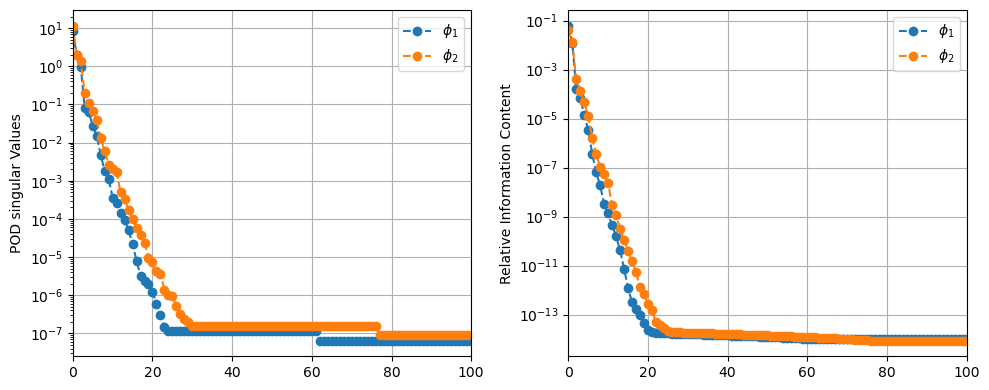

In [37]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

[axs[0].semilogy(np.sqrt(pod_offline[field].eigenvalues), '--o', label='$'+tex_var_names[field_i]+'$') for field_i, field in enumerate(var_names)]
axs[0].set_xlim(0,100)
axs[0].grid()
axs[0].set_ylabel('POD singular Values')
axs[0].legend()

[axs[1].semilogy(1-np.cumsum(pod_offline[field].eigenvalues) / np.sum(pod_offline[field].eigenvalues), '--o', label='$'+tex_var_names[field_i]+'$') for field_i, field in enumerate(var_names)]
axs[1].set_xlim(0,100)
axs[1].grid()
axs[1].set_ylabel('Relative Information Content')
axs[1].legend()

plt.tight_layout()

Let us compute the basis functions and the training error for the POD

In [38]:
maxBasis = 40

[pod_offline[field].compute_basis(train_snaps[field], maxBasis=maxBasis, normalise=True) for field in var_names]
basis_functions['POD'] = {field: pod_offline[field].PODmodes for field in var_names}

offline_errors['POD'] = {field: dict() for field in var_names}
offline_coefficients['POD'] = {field: None for field in var_names}

for field in var_names:
    offline_errors['POD'][field]['abs'], offline_errors['POD'][field]['rel'], offline_coefficients['POD'][field] = pod_offline[field].train_error(train_snaps[field], maxBasis=maxBasis, verbose=True)

Computing train error phi1: 500.000 / 500.00 - 0.011 s/it
Computing train error phi2: 500.000 / 500.00 - 0.011 s/it


### Generalised Empirical Interpolation Method
This algorithm is used to generate a set of magic functions and sensors

In [39]:
from pyforce.offline.geim import GEIM

geim_offline = {field: GEIM(domain, V, field, s=0.01) for field in var_names}

offline_errors['GEIM'] = {field: dict() for field in var_names}
offline_coefficients['GEIM'] = {field: None for field in var_names}
for field in var_names:
    offline_errors['GEIM'][field]['abs'], offline_errors['GEIM'][field]['rel'], offline_coefficients['GEIM'][field] = geim_offline[field].offline(train_snaps[field], maxBasis, sampleEvery = 5, verbose = True)
    print(' ')

basis_functions['GEIM'] = {field: geim_offline[field].magic_fun for field in var_names}
basis_sensors['GEIM'] = {field: geim_offline[field].magic_sens for field in var_names}

Generating sensors (sampled every 5 cells): 89.000 / 89.00 - 0.002 s/it
  Iteration 040 | Abs Err: 4.48e-11 | Rel Err: 1.38e-10
Generating sensors (sampled every 5 cells): 89.000 / 89.00 - 0.002 s/it
  Iteration 040 | Abs Err: 2.56e-09 | Rel Err: 4.09e-09


### Plotting offline results
The training error is plotted in terms of maximum absolute and relative error.

Text(0, 0.5, '$\\varepsilon_N$')

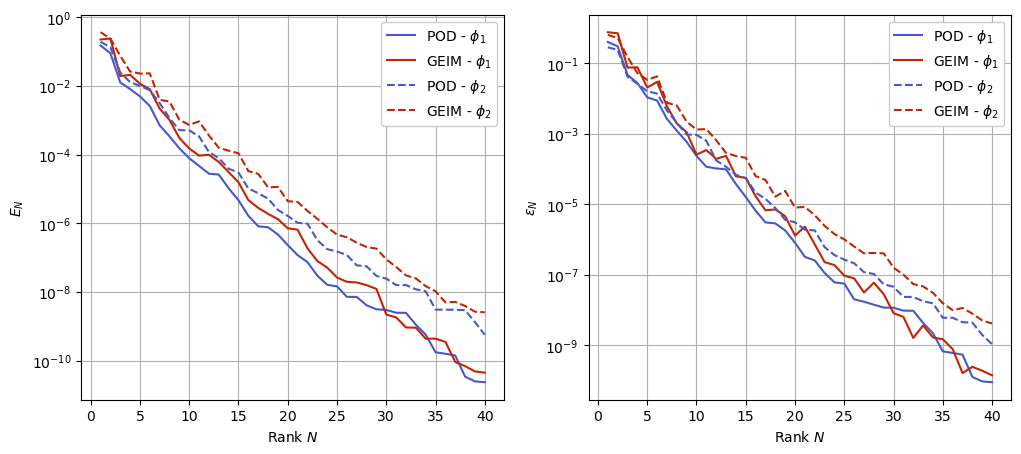

In [40]:
from matplotlib import cm

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

algos = list(offline_errors.keys())
colors = cm.turbo(np.linspace(0.1,0.9,len(algos)))

N_to_plot = np.arange(1, maxBasis+1, 1)

linestyles = ['-', '--']

for field_i, field in enumerate(var_names):
    for algo_i in range(len(algos)):
        axs[0].semilogy(N_to_plot, offline_errors[algos[algo_i]][field]['abs'], linestyles[field_i], c=colors[algo_i], label=algos[algo_i]+' - $'+tex_var_names[field_i]+'$')
        axs[1].semilogy(N_to_plot, offline_errors[algos[algo_i]][field]['rel'], linestyles[field_i], c=colors[algo_i], label=algos[algo_i]+' - $'+tex_var_names[field_i]+'$')
    
for ax in axs:
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.set_xlabel('Rank $N$')
    ax.set_xticks(np.arange(0, maxBasis+1, 5))
    ax.legend(framealpha=1)
axs[0].set_ylabel(r'$E_N$')
axs[1].set_ylabel(r'$\varepsilon_N$')

## Online Phase
In this section, the GEIM with noise and the Indirect Reconstruction algorithm will be discussed.

In [41]:
M_max = 15

obs_field_i = 0
nonobs_field_i = 1

online_dir_errors  = dict()
online_ir_errors  = dict()
online_comput_costs = dict()

### Generalised Empirical Interpolation Method
The sensors and the magic functions are used to estimate the online coefficients, considering meaures polluted by random noise

In [42]:
from pyforce.online.geim_synthetic import GEIM

geim_online = GEIM(basis_functions['GEIM'][var_names[obs_field_i]], basis_sensors['GEIM'][var_names[obs_field_i]], var_names[obs_field_i])

online_dir_errors['GEIM'] = dict()
online_dir_errors['GEIM']['abs'], online_dir_errors['GEIM']['rel'], online_comput_costs['GEIM'] = geim_online.synt_test_error(test_snaps[var_names[obs_field_i]], M_max, noise_value = 0.01, verbose=True)

Computing GEIM test error (synthetic) - phi1: 125.000 / 125.00 - 0.004 s/it


### Tikohonov Regularisation Generalised Empirical Interpolation Method
The sensors and the magic functions are used to estimate the online coefficients, considering meaures polluted by random noise. Regularisation is needed

In [43]:
from pyforce.online.tr_geim_synthetic import TRGEIM

mean_beta = offline_coefficients['GEIM'][var_names[obs_field_i]].mean(axis=0)
std_beta  = offline_coefficients['GEIM'][var_names[obs_field_i]].std(axis=0)

trgeim_online = TRGEIM(basis_functions['GEIM'][var_names[obs_field_i]], basis_sensors['GEIM'][var_names[obs_field_i]], 
                       mean_beta, std_beta, var_names[obs_field_i])

online_dir_errors['TRGEIM'] = dict()
online_dir_errors['TRGEIM']['abs'], online_dir_errors['TRGEIM']['rel'], online_comput_costs['TRGEIM'] = trgeim_online.synt_test_error(test_snaps[var_names[obs_field_i]], noise_value = 0.01, reg_param = 0.01**2, M=M_max, verbose=True)

Computing TR-GEIM test error (synthetic) - phi1: 125.000 / 125.00 - 0.004 s/it


### Indirect Reconstruction
The fields are coupled together, thus both carry information about the other. At first, let us build some interpolation/regression methods, starting from the training ones for the GEIM coefficients
\begin{equation*}
\mathcal{F}_m:\boldsymbol{\mu}\longrightarrow \beta_m(\boldsymbol{\mu})
\end{equation*}

In [44]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

# map_geim_coeff = [NearestNDInterpolator(mu_train[var_names[obs_field_i]], offline_coefficients['GEIM'][var_names[obs_field_i]][:,nn]) for nn in range(M_max)]
map_geim_coeff = [LinearNDInterpolator(mu_train[var_names[obs_field_i]], offline_coefficients['GEIM'][var_names[obs_field_i]][:,nn], fill_value=0) for nn in range(M_max)]

At first, the Parameter Estimation phase takes place

In [45]:
from pyforce.online.indirect_recon import PE
from pyforce.tools.backends import norms

norm = norms(V)
matrix_B = np.zeros((M_max, M_max))
for mm in range(M_max):
    for nn in range(M_max):
        if nn > mm:
            matrix_B[mm, nn] = 0.
        else:
            matrix_B[mm, nn] = norm.L2innerProd(basis_sensors['GEIM'][var_names[obs_field_i]](mm), 
                                                basis_functions['GEIM'][var_names[obs_field_i]](nn))

bnds = [(1, 3), (0.2,  0.5)]
pe_online = PE(matrix_B, map_geim_coeff, bnds)

res = pe_online.synt_test_error(mu_test[var_names[obs_field_i]], test_snaps[var_names[obs_field_i]],
                                basis_sensors['GEIM'][var_names[obs_field_i]], M_max,
                                noise_value = 0.01, verbose=True,
                                use_brute = True, grid_elem = 20)

online_ir_errors['abs'] = res[0]
online_ir_errors['rel'] = res[1]

mu_estimated = res[2]
online_comput_costs['PE'] = res[4]

  Delta = norm(x0 * scale_inv / v**0.5)



  alpha -= (phi + Delta) * ratio / Delta



Solving Parameter Estimation : 125.000 / 125.00 - 0.639 s/it


### POD with Interpolation
The reduced coefficients are estimated using interpolation/regression methods, starting from the training ones
\begin{equation*}
\mathcal{F}_n:\boldsymbol{\mu}\longrightarrow \alpha_n(\boldsymbol{\mu})
\end{equation*}

In [46]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

N_max = M_max

# map_pod_coeff = [NearestNDInterpolator(mu_train[var_names[nonobs_field_i]], offline_coefficients['POD'][var_names[nonobs_field_i]][:,nn]) for nn in range(N_max)]
map_pod_coeff = [LinearNDInterpolator(mu_train[var_names[nonobs_field_i]], offline_coefficients['POD'][var_names[nonobs_field_i]][:,nn], fill_value=offline_coefficients['POD'][var_names[nonobs_field_i]][:,nn].mean()) for nn in range(N_max)]

Once these maps are known, we can estimate the unseen parameters using POD-I

In [47]:
from pyforce.online.pod_interpolation import PODI

pod_interp_online = PODI(basis_functions['POD'][var_names[nonobs_field_i]], map_pod_coeff, var_names[nonobs_field_i])

online_ir_errors['PODI'] = dict()
online_ir_errors['PODI']['abs'], online_ir_errors['PODI']['rel'], online_comput_costs['PODI'] = pod_interp_online.synt_test_error(test_snaps[var_names[nonobs_field_i]], np.asarray(mu_estimated)[:, -1, :], N_max, verbose=True)

Computing POD test error (interpolation) - phi2: 125.000 / 125.00 - 0.004 s/it


### Plotting online errors and computational costs
The average absolute and relative errors on the test snapshots is plotted for each algorithm.

Text(0, 0.5, '$\\varepsilon_N$')

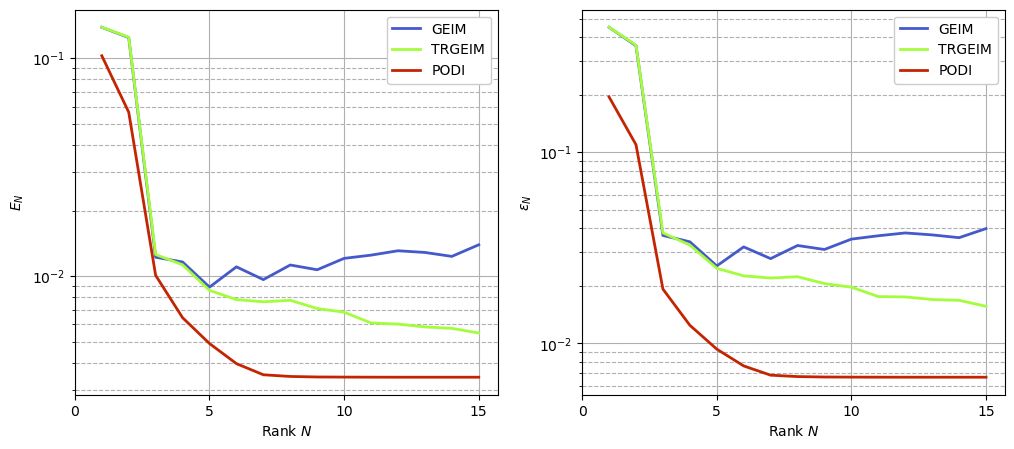

In [48]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

algos = list(online_dir_errors.keys())
colors = cm.turbo(np.linspace(0.1,0.9,len(algos)+1))

M_to_plot = np.arange(1, M_max+1, 1)

for algo_i in range(len(algos)):
    
    axs[0].semilogy(M_to_plot, online_dir_errors[algos[algo_i]]['abs'], c=colors[algo_i], label=algos[algo_i], linewidth = 2)
    axs[1].semilogy(M_to_plot, online_dir_errors[algos[algo_i]]['rel'], c=colors[algo_i], label=algos[algo_i], linewidth = 2)


N_to_plot = np.arange(1, N_max+1, 1)
axs[0].semilogy(N_to_plot, online_ir_errors['PODI']['abs'], c=colors[-1], label='PODI', linewidth = 2)
axs[1].semilogy(N_to_plot, online_ir_errors['PODI']['rel'], c=colors[-1], label='PODI', linewidth = 2)


for ax in axs:
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.set_xlabel('Rank $N$')
    ax.set_xticks(np.arange(0, N_max+1, 5))
    ax.legend(framealpha=1)
axs[0].set_ylabel(r'$E_N$')
axs[1].set_ylabel(r'$\varepsilon_N$')

Let us now plot the computational costs (the time given by the POD/PODI is specific to a single coefficient)

Text(0, 0.5, 'CPU time to estimate 10 coefficients (s)')

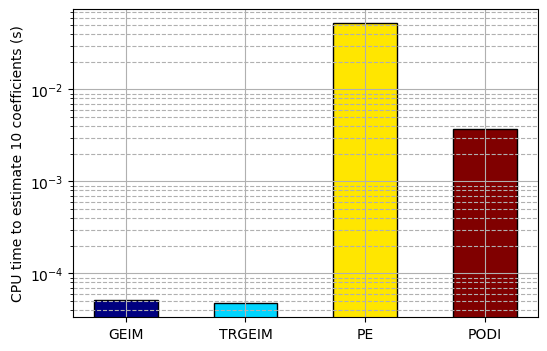

In [65]:
fig, axs = plt.subplots(figsize=(6,4))

algos = list(online_comput_costs.keys())

N_estimation = 10

width = 1.5
_algo = np.arange(0, width * len(algos), width)
ave_online_cost = [
    online_comput_costs['GEIM']['LinearSystem'].mean(axis=0)[N_estimation-1],
    online_comput_costs['TRGEIM']['LinearSystem'].mean(axis=0)[N_estimation-1],
    online_comput_costs['PE']['Optimisation'].mean(axis=0)[N_estimation-1],
    np.mean(online_comput_costs['PODI']['CoeffEstimation'].mean(axis=0)) * N_estimation,
]

axs.bar(_algo, ave_online_cost, color=cm.jet(np.linspace(0,1,len(algos))), edgecolor='k')
axs.set_xticks(_algo, algos)
axs.set_yscale('log')
axs.grid(which='major', linestyle='-')
axs.grid(which='minor', linestyle='--')
axs.set_ylabel('CPU time to estimate '+str(N_estimation)+' coefficients (s)')

### Plotting the reconstruction
The algorithms are used to estimate the full-order solution

In [69]:
N_to_use = 10
mu_to_recon = 25

reconstructions_obs = dict()
residuals_obs = dict()

# GEIM
reconstructions_obs['GEIM'], residuals_obs['GEIM'], _ = geim_online.reconstruct(test_snaps[var_names[obs_field_i]](mu_to_recon), N_to_use, noise_value = 0.01)

# TR-GEIM
reconstructions_obs['TRGEIM'], residuals_obs['TRGEIM'], _, _ = trgeim_online.reconstruct(test_snaps[var_names[obs_field_i]](mu_to_recon), N_to_use, noise_value = 0.01, reg_param = 0.01**2)

reconstructions_nonobs = dict()
residuals_nonobs = dict()

# POD - Interpolation
reconstructions_nonobs['PODI'], residuals_nonobs['PODI'], _ = pod_interp_online.reconstruct(test_snaps[var_names[nonobs_field_i]](mu_to_recon), np.asarray(mu_estimated)[mu_to_recon, -1, :].reshape(-1, 2), N_to_use)

Let us make some contour plots using `matplotlib`

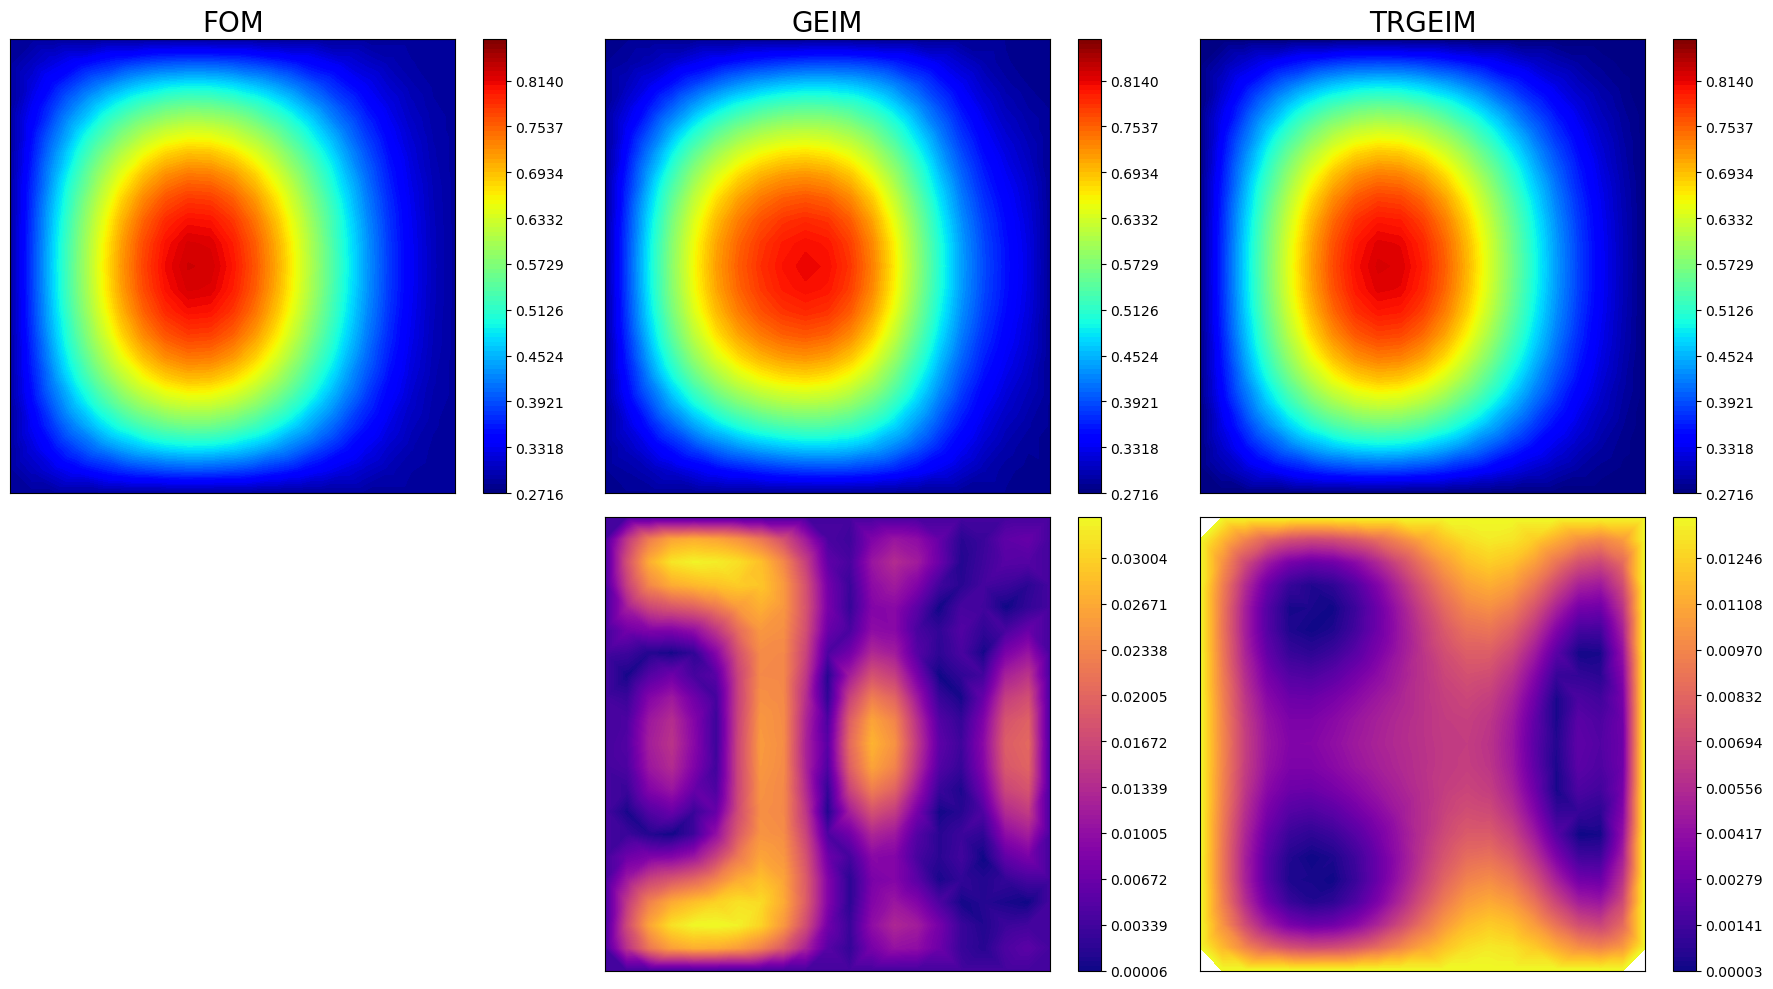

In [71]:
mesh = domain.geometry.x

algos = list(reconstructions_obs.keys())
assert len(algos) == len(residuals_obs.keys())

ncols = len(algos)+1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))

cmin = min(test_snaps[var_names[obs_field_i]](mu_to_recon)) * 0.95
cmax = max(test_snaps[var_names[obs_field_i]](mu_to_recon)) * 1.05

# FOM plot
plot1 = axs[0, 0].tricontourf(mesh[:,0], mesh[:,1], test_snaps[var_names[obs_field_i]](mu_to_recon), levels = np.linspace(cmin, cmax, 100), cmap=cm.jet, vmin=cmin, vmax=cmax)
plt.colorbar(plot1)
axs[0, 0].set_title('FOM', fontsize=20)

# Reconstructions
rec_plots = dict()
for algo_i in range(len(algos)):
    rec_plots[algos[algo_i]] = axs[0, 1+algo_i].tricontourf(mesh[:,0], mesh[:,1], reconstructions_obs[algos[algo_i]], levels = np.linspace(cmin, cmax, 100), cmap=cm.jet, vmin=cmin, vmax=cmax)
    plt.colorbar(rec_plots[algos[algo_i]])
    axs[0, 1+algo_i].set_title(algos[algo_i], fontsize=20)
    
# Residuals
res_plots = dict()
for algo_i in range(len(algos)):
    res_plots[algos[algo_i]] = axs[1, 1+algo_i].tricontourf(mesh[:,0], mesh[:,1], residuals_obs[algos[algo_i]], 
                                                            levels = np.linspace(min(residuals_obs[algos[algo_i]]), max(residuals_obs[algos[algo_i]]), 100), cmap=cm.plasma)
    plt.colorbar(res_plots[algos[algo_i]])
    
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
axs[1,0].axis('off')
plt.tight_layout()

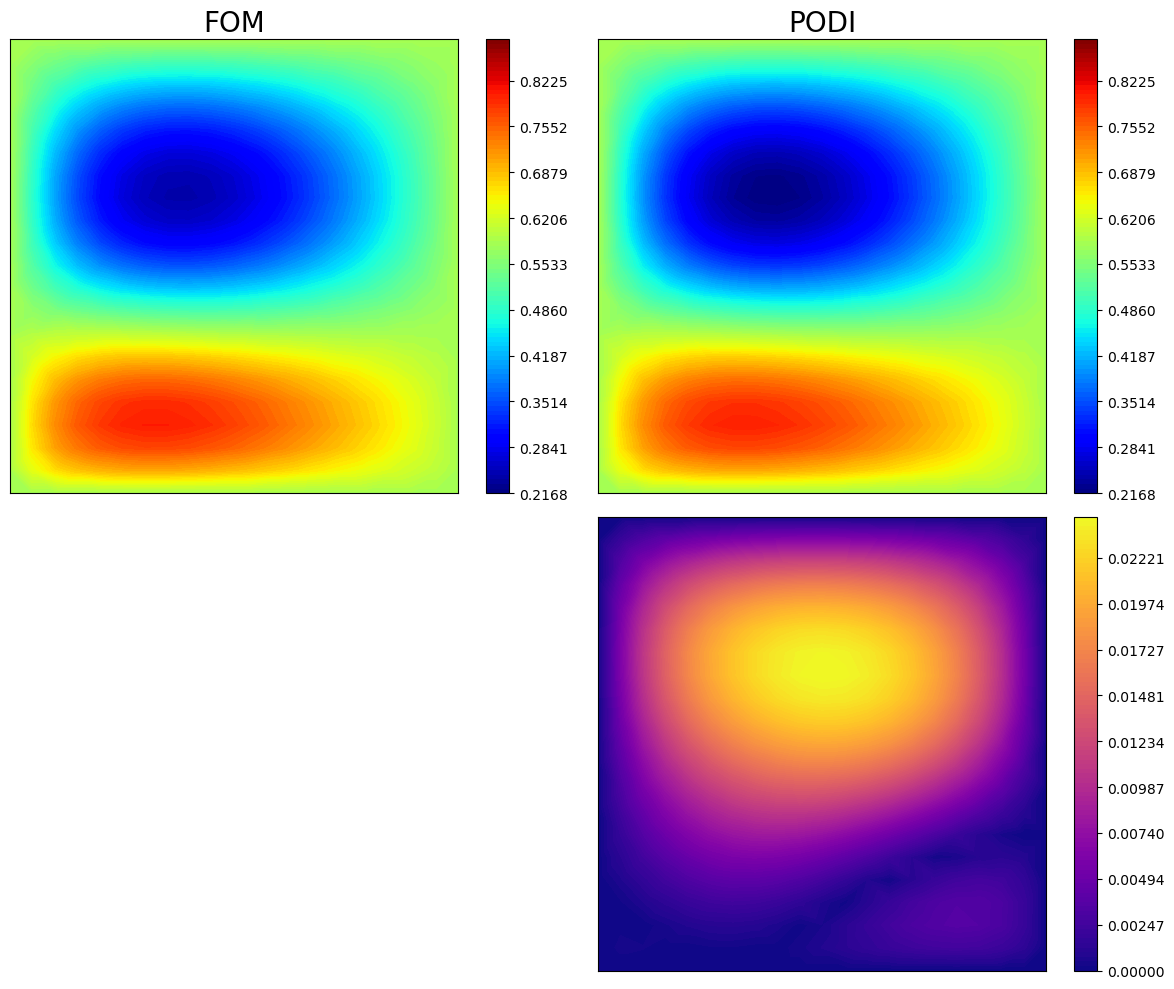

In [73]:
mesh = domain.geometry.x

algos = list(reconstructions_nonobs.keys())
assert len(algos) == len(residuals_nonobs.keys())

ncols = len(algos)+1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))

cmin = min(test_snaps[var_names[nonobs_field_i]](mu_to_recon)) * 0.9
cmax = max(test_snaps[var_names[nonobs_field_i]](mu_to_recon)) * 1.1

# FOM plot
plot1 = axs[0, 0].tricontourf(mesh[:,0], mesh[:,1], test_snaps[var_names[nonobs_field_i]](mu_to_recon), levels = np.linspace(cmin, cmax, 100), cmap=cm.jet, vmin=cmin, vmax=cmax)
plt.colorbar(plot1)
axs[0, 0].set_title('FOM', fontsize=20)

# Reconstructions
rec_plots = dict()
for algo_i in range(len(algos)):
    rec_plots[algos[algo_i]] = axs[0, 1+algo_i].tricontourf(mesh[:,0], mesh[:,1], reconstructions_nonobs[algos[algo_i]], levels = np.linspace(cmin, cmax, 100), cmap=cm.jet, vmin=cmin, vmax=cmax)
    plt.colorbar(rec_plots[algos[algo_i]])
    axs[0, 1+algo_i].set_title(algos[algo_i], fontsize=20)
    
# Residuals
res_plots = dict()
for algo_i in range(len(algos)):
    res_plots[algos[algo_i]] = axs[1, 1+algo_i].tricontourf(mesh[:,0], mesh[:,1], residuals_nonobs[algos[algo_i]], 
                                                            levels = np.linspace(min(residuals_nonobs[algos[algo_i]]), max(residuals_nonobs[algos[algo_i]]), 100), cmap=cm.plasma)
    plt.colorbar(res_plots[algos[algo_i]])
    
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
axs[1,0].axis('off')
plt.tight_layout()